In [ ]:
pip install yfinance

In [ ]:
import yfinance as yf

In [ ]:
!pip install PyPortfolioOpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.2 MB/s eta 0:00:00


In [ ]:
#Usual Suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import requests

# Use PyPortfolioOpt for Calculations
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import DiscreteAllocation

In [ ]:
#Create a Portfolio
symbols = ['AAPL', 'MSFT', 'NFLX', 'NVDA', 'FB', 'TWTR', 'TSLA', 'AMZN', 'WMT']

In [ ]:
#Get the stock data
portfolio = yf.download(symbols, start="2018-01-01", end="2023-02-28")['Adj Close']

portfolio.head()

[*********************100%%**********************]  9 of 9 completed

ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['TWTR', 'FB']: Exception('%ticker%: No timezone found, symbol may be delisted')


,AAPL,AMZN,FB,MSFT,NFLX,NVDA,TSLA,TWTR,WMT
Date,,,,,,,,,
2018-01-02 00:00:00,40.722874,59.450500,NaN,80.229012,201.070007,49.317131,21.368668,NaN,88.952385
2018-01-03 00:00:00,40.715786,60.209999,NaN,80.602371,205.050003,52.562874,21.150000,NaN,89.728317
2018-01-04 00:00:00,40.904911,60.479500,NaN,81.311813,205.630005,52.839943,20.974667,NaN,89.809517
2018-01-05 00:00:00,41.370625,61.457001,NaN,82.319908,209.990005,53.287724,21.105333,NaN,90.341850
2018-01-08 00:00:00,41.216957,62.343498,NaN,82.403915,212.050003,54.920498,22.427334,NaN,91.677200


In [ ]:
portfolio.to_csv('yfinance_data.csv', index=False)

In [ ]:
#SP500 ETF Benchmark
market_prices = yf.download("SPY", start='2018-01-01', end='2023-02-28')["Adj Close"]
market_prices.head()

[*********************100%%**********************]  1 of 1 completed


Date
2018-01-02    244.057770
2018-01-03    245.601517
2018-01-04    246.636703
2018-01-05    248.280258
2018-01-08    248.734299
Name: Adj Close, dtype: float64

In [ ]:
FMP_key = 'l8pd4pI8EAOGK98m25gxBKdlQIfgiWp1'

# Define a function to get the url based on your API key and
def url(symbol: str, api_key):
    return "https://financialmodelingprep.com/api/v3/market-capitalization/" + symbol + "?apikey=" + api_key

mcaps = {}

# Iterate based on the symbols list and add to DataFrame
for item in symbols:
    response = requests.get(url(symbol = item, api_key = FMP_key)).json()
    # symbols.append(response[0]['symbol'])
    mcaps[item] = response[0]['marketCap']
    # market_caps.append(response[0]['marketCap'])
mcaps

{'AAPL': 2977583510989,
 'MSFT': 2805232250634,
 'NFLX': 207666029600,
 'NVDA': 1245102364524,
 'FB': 458694753100,
 'TWTR': 41093709770,
 'TSLA': 748953536922,
 'AMZN': 1510107438705,
 'WMT': 417999258061}

In [ ]:
marketcap_df=pd.DataFrame(mcaps)

TypeError: ignored

## Step 2: Getting Priors

In [ ]:
#Calculate Sigma and Delta to get implied market returns
#Ledoit-Wolf is a particular form of shrinkage, where the shrinkage coefficient is computed using O?
S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()

delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.0907109252755722

<Axes: >

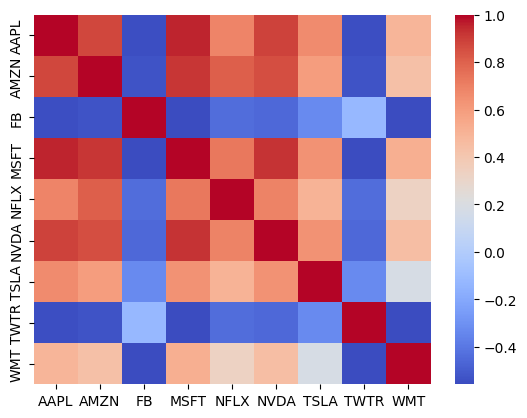

In [ ]:
#Visualize the Covariant Correlation
sns.heatmap(S.corr(), cmap='coolwarm')

In [ ]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AAPL    0.203052
AMZN    0.201251
FB      0.020126
MSFT    0.193846
NFLX    0.200602
NVDA    0.289660
TSLA    0.277143
TWTR    0.020011
WMT     0.081093
dtype: float64

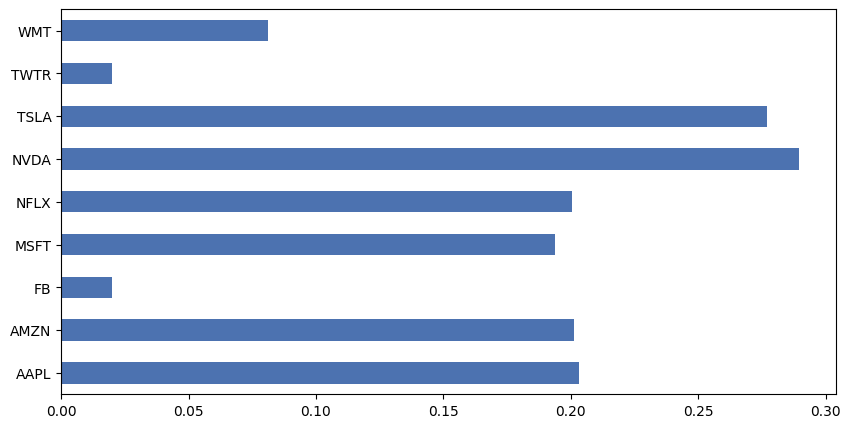

In [ ]:
#What am I looking at here?
market_prior.plot.barh(figsize=(10,5));

## Step 3: Integrating Views

In [ ]:
#You don't have to provide views on all the assets
viewdict = {
    'AAPL':0.10,
    'MSFT':0.10,
    'FB':0.05,
    'AMZN':0.30,
    'NFLX':0.02,
    'NVDA':0.01,
    'TSLA':0.15,
    'TWTR':0.09,
    'WMT':0.16}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

### Creating Confidences

we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [ ]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9)]

In [ ]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003]


# Step 4: Calculate Posterior Estimate Returns

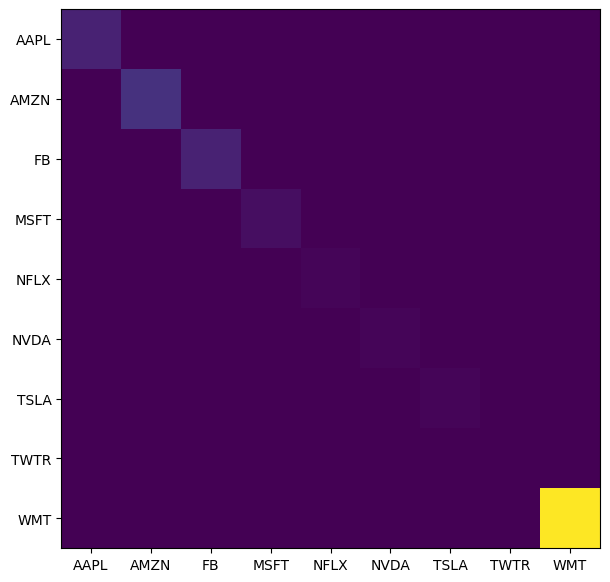

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [ ]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [ ]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AAPL    0.114847
AMZN    0.160065
FB      0.000341
MSFT    0.107755
NFLX    0.048431
NVDA    0.061646
TSLA    0.148862
TWTR    0.013036
WMT     0.041399
dtype: float64

In [ ]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AAPL,0.203052,0.114847,0.10
AMZN,0.201251,0.160065,0.30
FB,0.020126,0.000341,0.05
MSFT,0.193846,0.107755,0.10
NFLX,0.200602,0.048431,0.02
NVDA,0.289660,0.061646,0.01
TSLA,0.277143,0.148862,0.15
TWTR,0.020011,0.013036,0.09
WMT,0.081093,0.041399,0.16


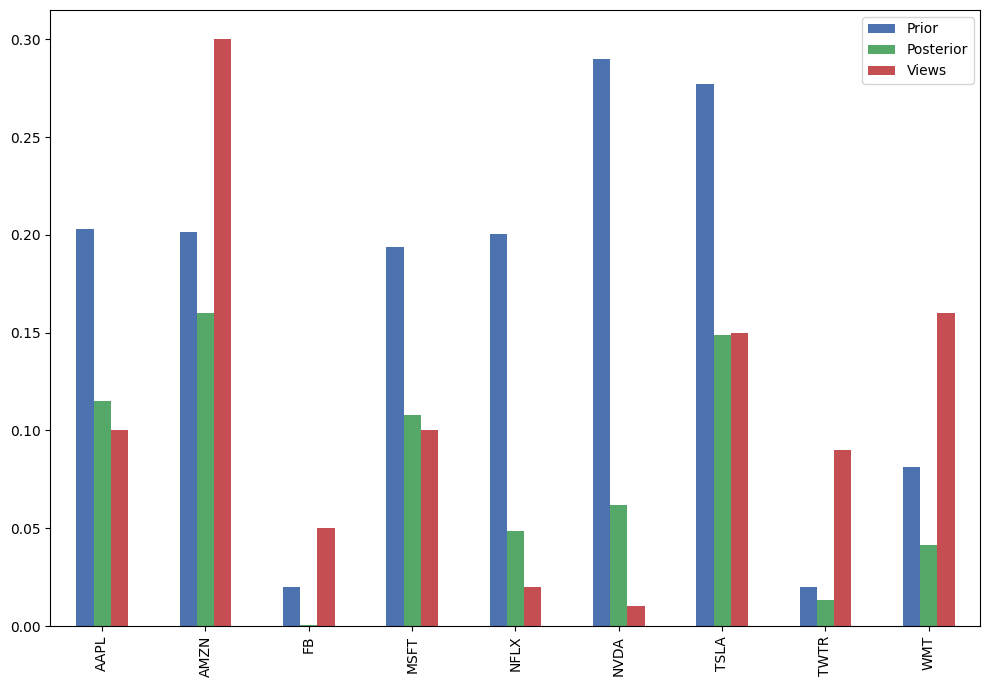

In [ ]:
rets_df.plot.bar(figsize=(12,8));

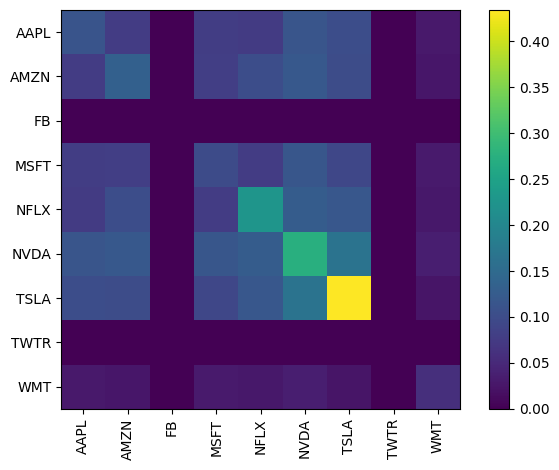

In [ ]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

# Step 5: Portfolio Allocation

In [ ]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AAPL', 0.20601),
             ('AMZN', 0.33593),
             ('FB', 0.0),
             ('MSFT', 0.18831),
             ('NFLX', 0.0),
             ('NVDA', 0.00397),
             ('TSLA', 0.22802),
             ('TWTR', 0.0),
             ('WMT', 0.03776)])

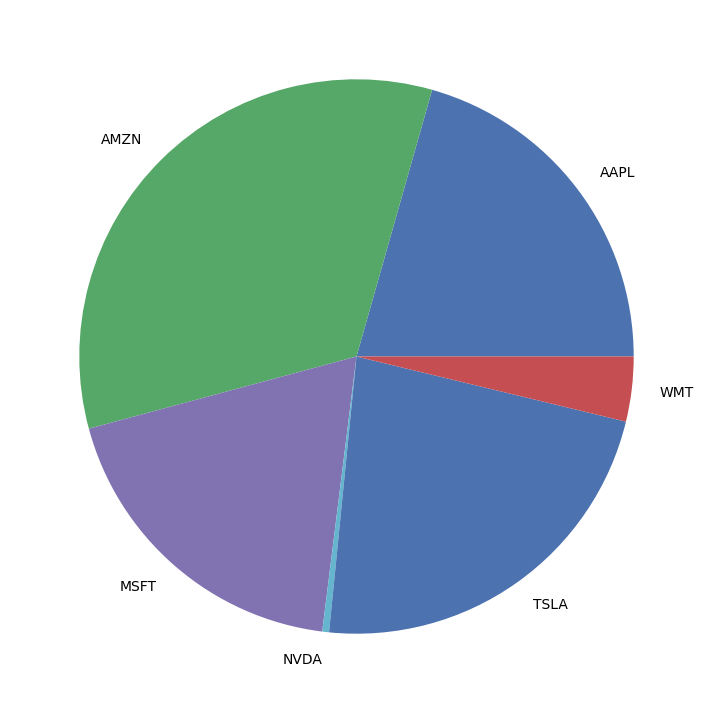

In [ ]:
pd.Series(weights).plot.pie(figsize=(9,9));

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


Expected annual return: 13.3%
Annual volatility: 33.0%
Sharpe Ratio: 0.34


/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(0.13347298379325676, 0.3300454869883968, 0.3438101360775342)

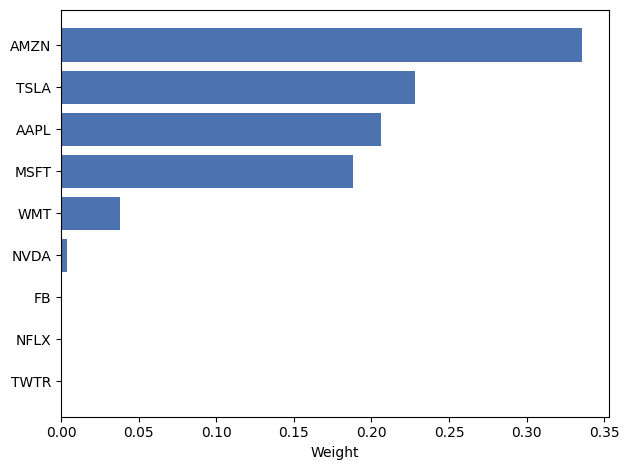

In [ ]:
from pypfopt.plotting import plot_weights

# Maximum Sharpe
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()

plot_weights(weights)
ef.portfolio_performance(verbose = True, risk_free_rate = 0.009)